### Keras CNN으로 폐렴 분류
#### 1. import packages & set parameters

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras.models import Model
from keras.layers import Conv2D, SeparableConv2D, Input, Flatten, BatchNormalization, MaxPool2D, Dense, Dropout
from keras.preprocessing.image import load_img
from sklearn.metrics import f1_score, confusion_matrix

Using TensorFlow backend.


In [2]:
# hyperparameters
MY_EPOCH = 50
MY_BATCH = 100
MY_RES = 180    # 사진 가로*세로 픽셀수 (해상도)
MY_SHAPE = (MY_RES, MY_RES, 3) # 그레이스케일 X-ray를 컬러카메라로 찍었기 때문에 3채널
TRAIN_MODE = 1
MY_PATH = './chest'

#### 2. load dataset & data preprocessing

In [3]:
# 변수
# T_tot = 학습용 이미지 개수
# V_tot = 평가용 이미지 개수
# N_tot = 정상 이미지 개수
# P_tot = 폐렴 이미지 개수
# N_path = 정상 이미지 경로
# P_path = 폐렴 이미지 경로

# 학습용 입력 이미지 경로 처리
def train_path():
    N_path, P_path = [], []
    for fname in os.listdir(MY_PATH + '/train/NORMAL/'):
        N_path.append(os.path.join(MY_PATH + '/train/NORMAL/', fname))

    for fname in os.listdir(MY_PATH + '/train/PNEUMONIA/'):
        P_path.append(os.path.join(MY_PATH + '/train/PNEUMONIA/', fname))

    N_tot, P_tot = len(N_path), len(P_path)
    T_tot = N_tot + P_tot

    print('Training normal data:', N_tot)
    print('Training pneumonia data:', P_tot)
    print('Training data total:', T_tot)

    return T_tot, N_tot, N_path, P_path

In [4]:
# 학습용 입력 이미지 처리
def train_data(T_tot, N_tot, N_path, P_path):
    # 정상 사진 처리
    X_train = np.zeros((T_tot, MY_RES, MY_RES, 3)) # 원소가 0인 m*n*o*p 행렬 생성
    Y_train = np.zeros((T_tot,)) # 라벨은 이미지 개수만큼 필요함

    for i, path in enumerate(N_path):
        img = load_img(path, target_size=(MY_RES, MY_RES))
        X_train[i] = img
        Y_train[i] = 0 # 정상 이미지는 라벨 0
  
    # 폐렴 사진 처리
    for i, path in enumerate(P_path):
        img = load_img(path, target_size=(MY_RES, MY_RES))
        X_train[i + N_tot] = img
        Y_train[i + N_tot] = 1 # 폐렴 이미지는 라벨 1
  
    # 결국 이 문제는 Binary Classification 문제
    # [0, 1 스케일링]
    X_train = X_train / 255

    return X_train, Y_train

In [5]:
def test_path():
    N_path, P_path = [], []
    for fname in os.listdir(MY_PATH + '/test/NORMAL/'):
        N_path.append(os.path.join(MY_PATH + '/test/NORMAL/', fname))
    N_tot = len(N_path)

    for fname in os.listdir(MY_PATH + '/test/PNEUMONIA/'):
        P_path.append(os.path.join(MY_PATH + '/test/PNEUMONIA/', fname))
    P_tot = len(P_path)
    V_tot = N_tot + P_tot

    print('Validation normal data:', N_tot)
    print('Validation pneumonia data:', P_tot)
    print('Validation data total:', V_tot)

    return V_tot, N_tot, N_path, P_path

In [6]:
def test_data(V_tot, N_tot, N_path, P_path):
    # 정상 사진 처리
    X_test = np.zeros((V_tot, MY_RES, MY_RES, 3)) # 원소가 0인 m*n*o*p 행렬 생성
    Y_test = np.zeros((V_tot,)) # 라벨은 이미지 개수만큼 필요함

    for i, path in enumerate(N_path):
        img = load_img(path, target_size=(MY_RES, MY_RES))
        X_test[i] = img
        Y_test[i] = 0 # 정상 이미지는 라벨 0
  
    # 폐렴 사진 처리
    for i, path in enumerate(P_path):
        img = load_img(path, target_size=(MY_RES, MY_RES))
        X_test[i + N_tot] = img
        Y_test[i + N_tot] = 1 # 폐렴 이미지는 라벨 1
  
    # 결국 이 문제는 Binary Classification 문제
    # [0, 1 스케일링]
    X_test = X_test / 255

    return X_test, Y_test

In [7]:
# 학습용 데이터 구현
if TRAIN_MODE:
    T_tot, N_tot, N_path, P_path = train_path()
    X_train, Y_train = train_data(T_tot, N_tot, N_path, P_path)

V_tot, N_tot, N_path, P_path = test_path()
X_test, Y_test = test_data(V_tot, N_tot, N_path, P_path)

if TRAIN_MODE:
    print('Training Input shape:', X_train.shape)
    print('Training Label shape:', Y_train.shape)
    
print('Validation Input shape:', X_test.shape)
print('Validation Label shape:', Y_test.shape)  

Training normal data: 500
Training pneumonia data: 500
Training data total: 1000
Validation normal data: 100
Validation pneumonia data: 100
Validation data total: 200
Training Input shape: (1000, 180, 180, 3)
Training Label shape: (1000,)
Validation Input shape: (200, 180, 180, 3)
Validation Label shape: (200,)


[]

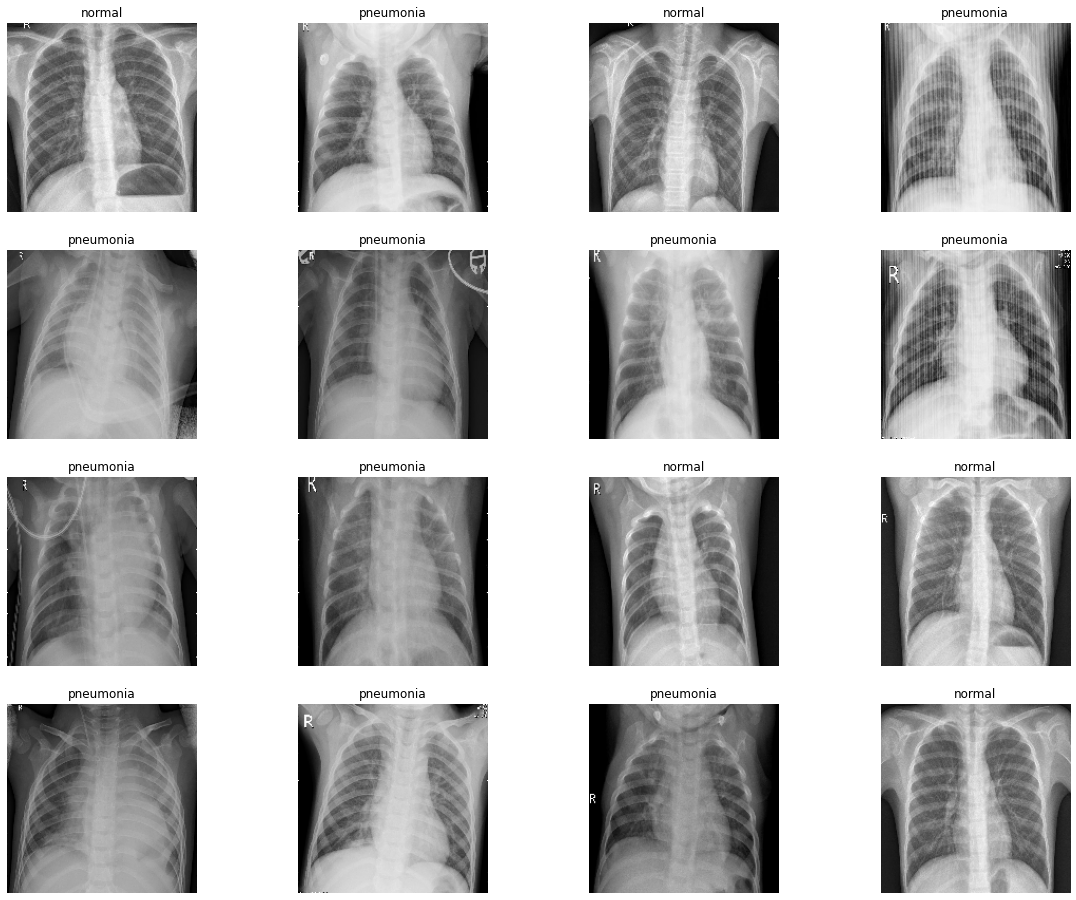

In [8]:
# 샘플이미지 16개 출력
pick = random.sample(range(0, V_tot), 16)
fig, spot = plt.subplots(4, 4, figsize=(20, 16))
cnt = 0

for i in range(4):
    for j in range(4):
        spot[i, j].imshow(X_test[pick[cnt]])
        
        if (Y_test[pick[cnt]]): # Y_test == 1이면 폐렴
            spot[i, j].title.set_text('pneumonia')
        else: # 0이면 정상
            spot[i, j].title.set_text('normal')
        
        spot[i, j].axis('off')
        cnt += 1

plt.axis('off')
plt.plot()

#### 3. Model creating

In [9]:
# using Functional API (not using Sequential API)

# Convolution Block
def conv_block(filters, inputs):
    x = SeparableConv2D(filters=filters, kernel_size=3,
                        activation='relu', padding='same')(inputs)
    x = SeparableConv2D(filters=filters, kernel_size=3,
                        activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    outputs = MaxPool2D(pool_size=2)(x)
    
    return outputs

In [10]:
# Dense Block
def dense_block(units, dropout_rate, inputs):
    x = Dense(units=units,
              activation='relu')(inputs)
    x = BatchNormalization()(x)
    outputs = Dropout(dropout_rate)(x)
    
    return outputs

In [11]:
def build_model():
    # Input Layer
    inputs = Input(shape=(MY_SHAPE))
    
    # Conv Block 1
    x = Conv2D(filters=16, kernel_size=3, 
               activation='relu', padding='same')(inputs)
    
    # Conv Block 2
    x = Conv2D(filters=16, kernel_size=3, 
               activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=2)(x)
    
    # Conv Block 3
    x = conv_block(32, x)
    x = conv_block(64, x)
    x = conv_block(128, x)
    x = Dropout(0.2)(x)
    
    # Conv Block 4
    x = conv_block(256, x)
    x = Dropout(0.2)(x)
    
    # Fully-connected
    x = Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)
    outputs = Dense(units=1, activation='sigmoid')(x) # binary classification
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 90, 90, 32)        688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 90, 90, 32)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 32)        128 

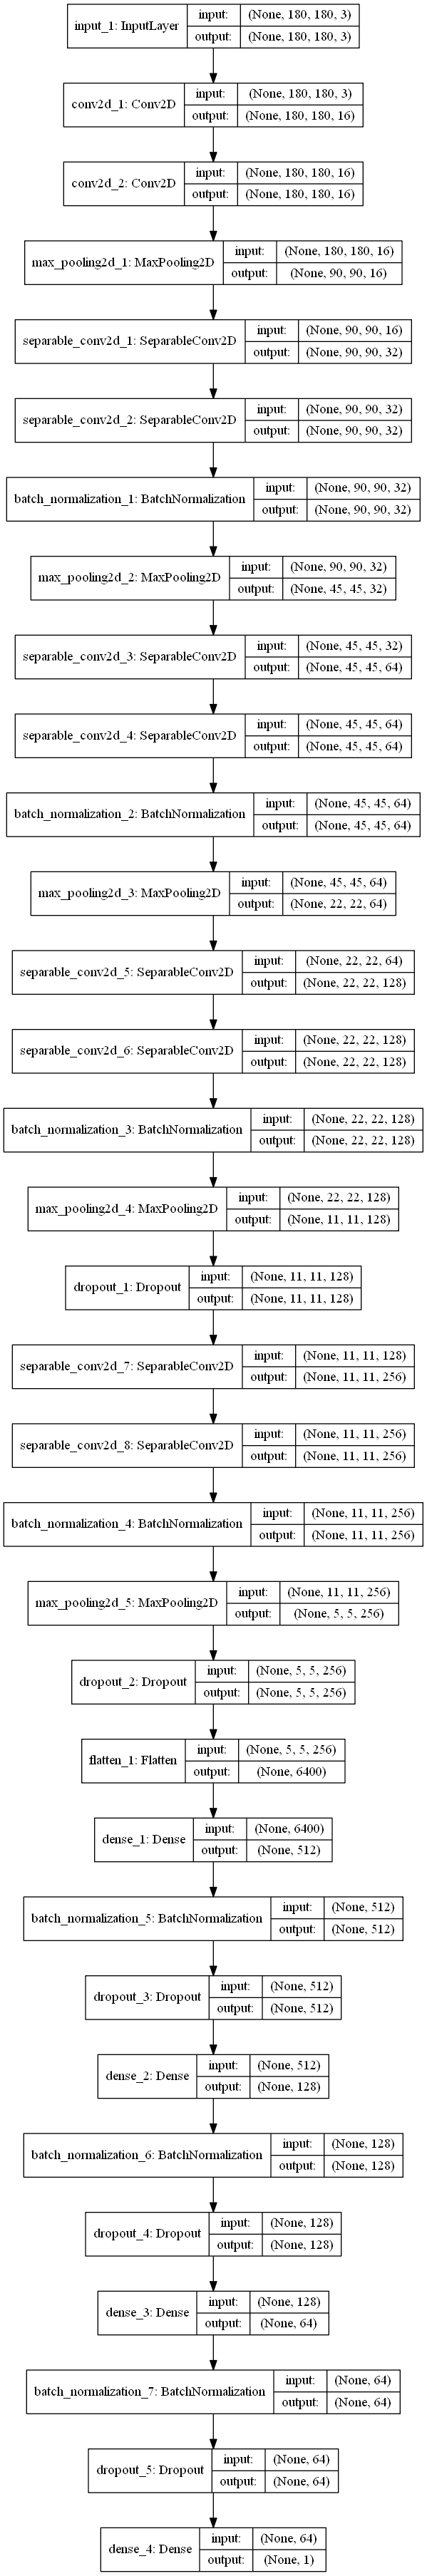

In [13]:
import pydot
from keras.utils import plot_model

plot_model(model, show_shapes=True)

#### 4. Model training & evaluation & prediction

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['acc']) # binary classification

In [15]:
def train_CNN():
    begin = time()
    model.fit(x=X_train, y=Y_train, shuffle=True,
              epochs=MY_EPOCH, batch_size=MY_BATCH, verbose=1)
    end = time()
    print('Total learning time: {:.2f}sec'.format(end - begin))

In [16]:
if TRAIN_MODE:
    train_CNN()
    model.save_weights('pneumonia.h5')
else:
    model.load_weights('pneumonia.h5')

Epoch 1/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7135 - acc: 0.6440
Epoch 2/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3920 - acc: 0.8330
Epoch 3/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2972 - acc: 0.8840
Epoch 4/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2582 - acc: 0.8890
Epoch 5/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2025 - acc: 0.9130
Epoch 6/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1683 - acc: 0.9340
Epoch 7/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1457 - acc: 0.9490
Epoch 8/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1476 - acc: 0.9470
Epoch 9/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1239 - acc: 0.9520
Epoch 10/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1059 - acc: 0.9590
Epoch 11/50
1000/1000 [======

In [17]:
score = model.evaluate(x=X_test, y=Y_test, verbose=1)
print('Loss:', score[0])
print('Accuracy:', score[1])

200/200 [==============================] - 1s 4ms/step
Loss: 4.720687116729677
Accuracy: 0.5


In [18]:
pred = model.predict(X_test)
pred = np.squeeze(pred)
print(pred)
pred = (pred > 0.5)
print(pred)

[0.99992085 0.99992216 0.9999237  0.9999218  0.9999232  0.9999205
 0.9999198  0.99992025 0.99992144 0.9999188  0.9999217  0.9999229
 0.99992156 0.9999219  0.99992466 0.9999217  0.9999232  0.99992085
 0.99991596 0.9999212  0.99992275 0.9999206  0.99991965 0.99992263
 0.99992096 0.99992085 0.99992204 0.9999217  0.9999217  0.99992144
 0.9999218  0.9999229  0.9999223  0.9999219  0.9999238  0.9999199
 0.99991596 0.9999206  0.99991775 0.99991846 0.9999211  0.9999194
 0.99991965 0.99991775 0.9999232  0.9999224  0.99992216 0.9999225
 0.99992216 0.99992096 0.99992    0.99991906 0.9999236  0.9999187
 0.99992335 0.9999218  0.99992037 0.99992216 0.9999174  0.9999213
 0.9999199  0.9999157  0.99992037 0.9999188  0.99992037 0.9999217
 0.9999211  0.99992096 0.9999181  0.9999193  0.99992025 0.9999205
 0.99991655 0.99992096 0.99991775 0.99992156 0.99991727 0.9999181
 0.99992    0.99991965 0.99991786 0.99992263 0.99991775 0.9999201
 0.9999175  0.9999186  0.99992156 0.9999223  0.99992025 0.99991727
 0.999

In [19]:
# Ref: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

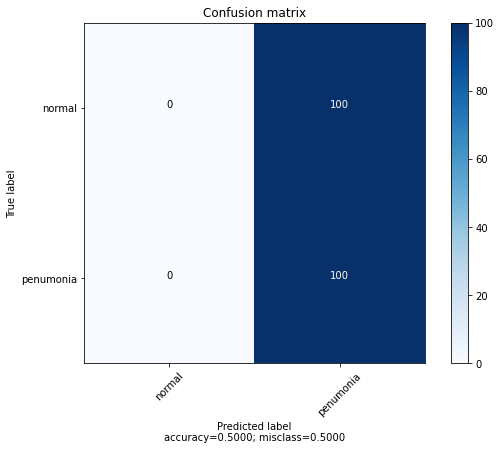

In [20]:
class_names = ['normal', 'penumonia']
confusion_mat = confusion_matrix(Y_test, pred)

disp = plot_confusion_matrix(confusion_mat, target_names=class_names,
                             normalize=False)

In [21]:
f1_score(Y_test, pred, average='micro')

0.5

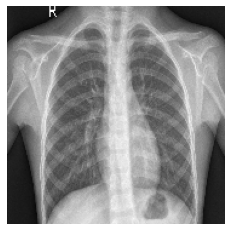

CNN Prediction: True
Truth: False


In [22]:
plt.imshow(X_test[0])
plt.axis('off')
plt.show()

print('CNN Prediction:', pred[0])
print('Truth:', bool(Y_test[0]))